# Regression Model for Kaggle Tabular Playground Series Aug 2021 Using Python and Scikit-learn
### David Lowe
### September 6, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Series Aug 2021 dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The February dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the loss from a loan default. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The average performance of the machine learning algorithms achieved an RMSE benchmark of 8.0771 using the training dataset. We selected ElasticNet and Gradient Boosting to perform the tuning exercises. After a series of tuning trials, the refined Gradient Boosting model processed the training dataset with a final RMSE score of 7.8563. When we processed Kaggle's test dataset with the final model, the model achieved an RMSE score of 7.8416.

CONCLUSION: In this iteration, the Gradient Boosting model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground Series Aug 2021 Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-aug-2021

One potential source of performance benchmarks: https://www.kaggle.com/c/tabular-playground-series-aug-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
import zipfile
import boto3
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = True

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'neg_mean_squared_error'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021aug/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id        f0   f1        f2        f3          f4        f5        f6  \
0   0 -0.002350   59  0.766739 -1.350460     42.2727  16.68570   30.3599   
1   1  0.784462  145 -0.463845 -0.530421  27324.9000   3.47545  160.4980   
2   2  0.317816   19 -0.432571 -0.382644   1383.2600  19.71290   31.1026   
3   3  0.210753   17 -0.616454  0.946362   -119.2530   4.08235  185.2570   
4   4  0.439671   20  0.968126 -0.092546     74.3020  12.30650   72.1860   

         f7         f8  ...        f91        f92      f93       f94  \
0  1.267300   0.392007  ...  -42.43990  26.854000  1.45751  0.696161   
1  0.828007   3.735860  ... -184.13200   7.901370  1.70644 -0.494699   
2 -0.515354  34.430800  ...    7.43721  37.218100  3.25339  0.337934   
3  1.383310 -47.521400  ...    9.66778   0.626942  1.49425  0.517513   
4 -0.233964  24.399100  ...  290.65700  15.604300  1.73557 -0.476668   

         f95       f96       f97      f98       f99  loss  
0   0.941764  1.828470  0.924090  2.29658  10.4898

In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 102 columns):
 #    Column  Dtype  
---   ------  -----  
 0    id      int64  
 1    f0      float64
 2    f1      int64  
 3    f2      float64
 4    f3      float64
 5    f4      float64
 6    f5      float64
 7    f6      float64
 8    f7      float64
 9    f8      float64
 10   f9      float64
 11   f10     float64
 12   f11     float64
 13   f12     float64
 14   f13     float64
 15   f14     float64
 16   f15     float64
 17   f16     int64  
 18   f17     float64
 19   f18     float64
 20   f19     float64
 21   f20     float64
 22   f21     float64
 23   f22     float64
 24   f23     float64
 25   f24     float64
 26   f25     float64
 27   f26     float64
 28   f27     int64  
 29   f28     float64
 30   f29     float64
 31   f30     float64
 32   f31     float64
 33   f32     float64
 34   f33     float64
 35   f34     float64
 36   f35     float64
 37   f36     float64
 38   f3

In [12]:
print(df_dataset_import.describe())

                  id             f0             f1             f2  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean   124999.500000       0.511213      51.378476       0.107155   
std     72168.927986       0.307884      42.396636       1.322200   
min         0.000000      -0.069273     -17.000000      -7.895580   
25%     62499.750000       0.251287      18.000000      -0.611172   
50%    124999.500000       0.514962      41.000000       0.253815   
75%    187499.250000       0.777322      75.000000       0.759249   
max    249999.000000       1.072070     273.000000       9.768590   

                  f3             f4             f5             f6  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean        0.050010    3595.133426       8.205953     164.508753   
std         0.792368    6072.401061       5.475723     183.335563   
min        -1.475560   -7589.280000      -3.291050     -40.967200   
25%        -0.719418     163.8647

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id      0
f0      0
f1      0
f2      0
f3      0
       ..
f96     0
f97     0
f98     0
f99     0
loss    0
Length: 102, dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [14]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'loss':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

         f0   f1        f2        f3          f4        f5        f6  \
0 -0.002350   59  0.766739 -1.350460     42.2727  16.68570   30.3599   
1  0.784462  145 -0.463845 -0.530421  27324.9000   3.47545  160.4980   
2  0.317816   19 -0.432571 -0.382644   1383.2600  19.71290   31.1026   
3  0.210753   17 -0.616454  0.946362   -119.2530   4.08235  185.2570   
4  0.439671   20  0.968126 -0.092546     74.3020  12.30650   72.1860   

         f7         f8       f9  ...        f91        f92      f93       f94  \
0  1.267300   0.392007  1.09101  ...  -42.43990  26.854000  1.45751  0.696161   
1  0.828007   3.735860  1.28138  ... -184.13200   7.901370  1.70644 -0.494699   
2 -0.515354  34.430800  1.24210  ...    7.43721  37.218100  3.25339  0.337934   
3  1.383310 -47.521400  1.09130  ...    9.66778   0.626942  1.49425  0.517513   
4 -0.233964  24.399100  1.10151  ...  290.65700  15.604300  1.73557 -0.476668   

         f95       f96       f97      f98       f99  target  
0   0.941764  1.82

In [15]:
print(df_dataset_import.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 101 columns):
 #    Column  Dtype  
---   ------  -----  
 0    f0      float64
 1    f1      int64  
 2    f2      float64
 3    f3      float64
 4    f4      float64
 5    f5      float64
 6    f6      float64
 7    f7      float64
 8    f8      float64
 9    f9      float64
 10   f10     float64
 11   f11     float64
 12   f12     float64
 13   f13     float64
 14   f14     float64
 15   f15     float64
 16   f16     int64  
 17   f17     float64
 18   f18     float64
 19   f19     float64
 20   f20     float64
 21   f21     float64
 22   f22     float64
 23   f23     float64
 24   f24     float64
 25   f25     float64
 26   f26     float64
 27   f27     int64  
 28   f28     float64
 29   f29     float64
 30   f30     float64
 31   f31     float64
 32   f32     float64
 33   f33     float64
 34   f34     float64
 35   f35     float64
 36   f36     float64
 37   f37     float64
 38   f3

In [16]:
print(df_dataset_import.describe())

                  f0             f1             f2             f3  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean        0.511213      51.378476       0.107155       0.050010   
std         0.307884      42.396636       1.322200       0.792368   
min        -0.069273     -17.000000      -7.895580      -1.475560   
25%         0.251287      18.000000      -0.611172      -0.719418   
50%         0.514962      41.000000       0.253815       0.004099   
75%         0.777322      75.000000       0.759249       0.765456   
max         1.072070     273.000000       9.768590       1.680190   

                  f4             f5             f6             f7  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean     3595.133426       8.205953     164.508753       0.375533   
std      6072.401061       5.475723     183.335563       0.813597   
min     -7589.280000      -3.291050     -40.967200      -4.143080   
25%       163.864750       4.1101

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

f0        0
f1        0
f2        0
f3        0
f4        0
         ..
f96       0
f97       0
f98       0
f99       0
target    0
Length: 101, dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

In [19]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (250000, 101) df_features_train.shape: (250000, 100) df_target_train.shape: (250000,)


In [20]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [21]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

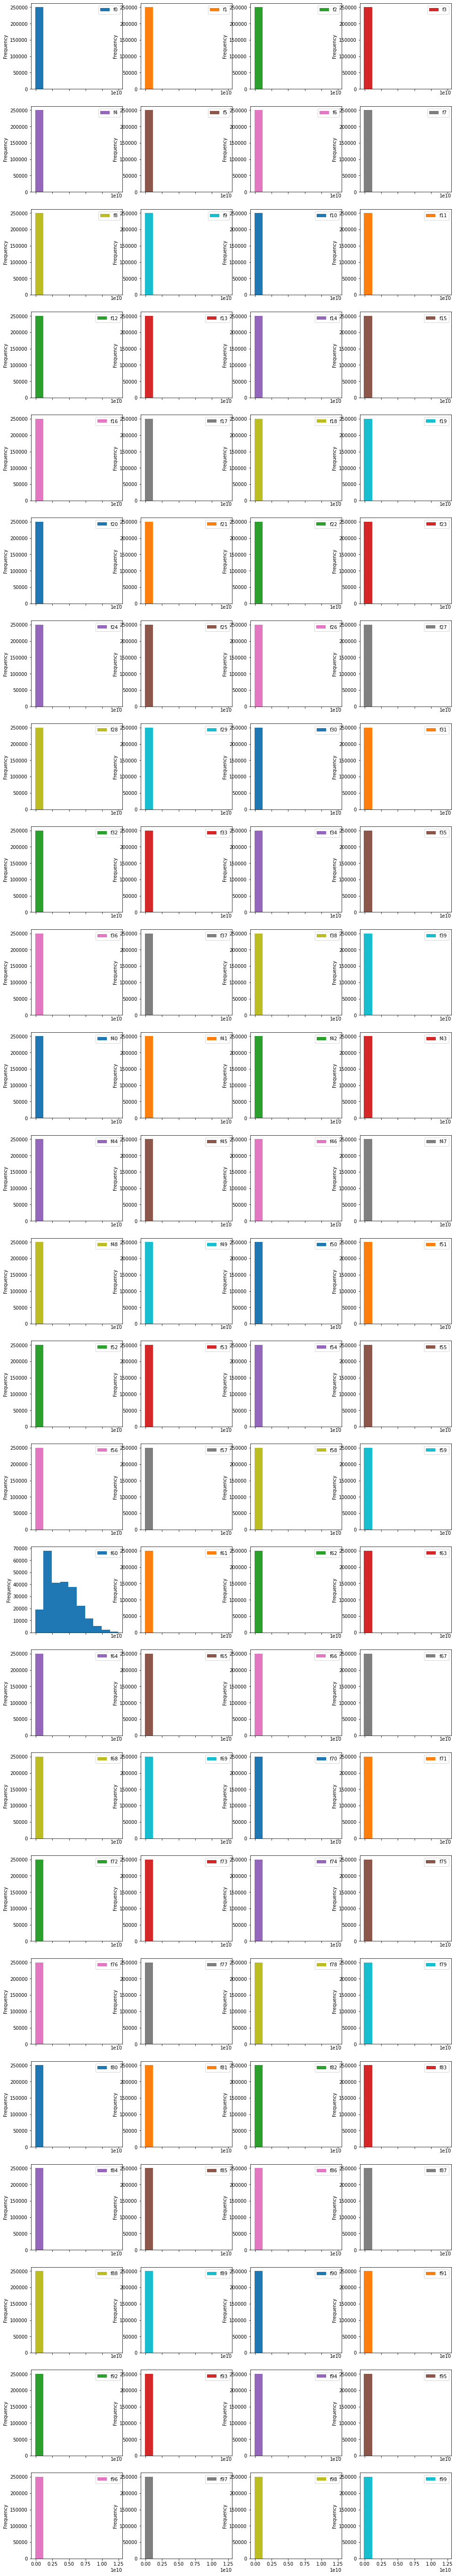

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

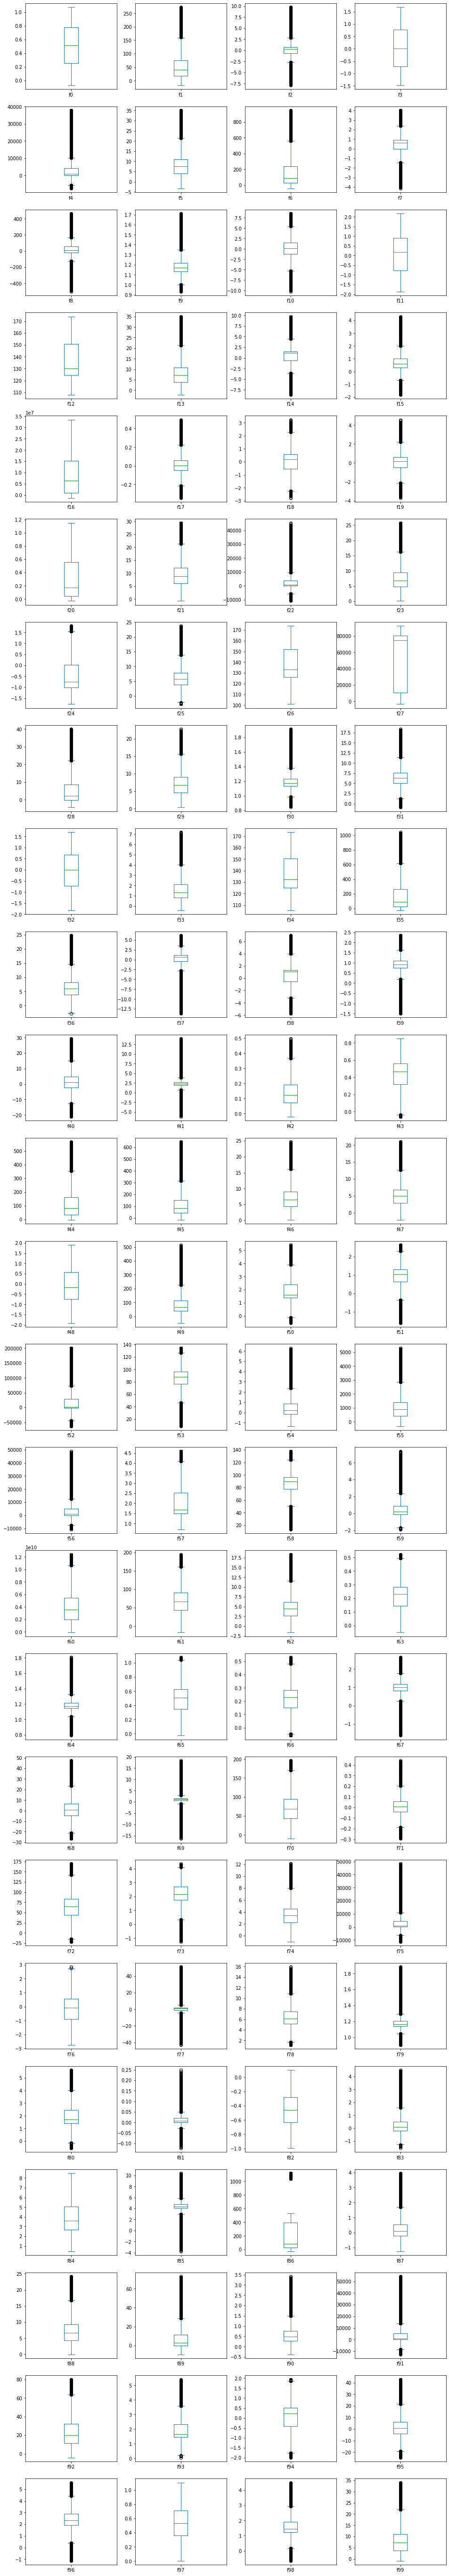

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

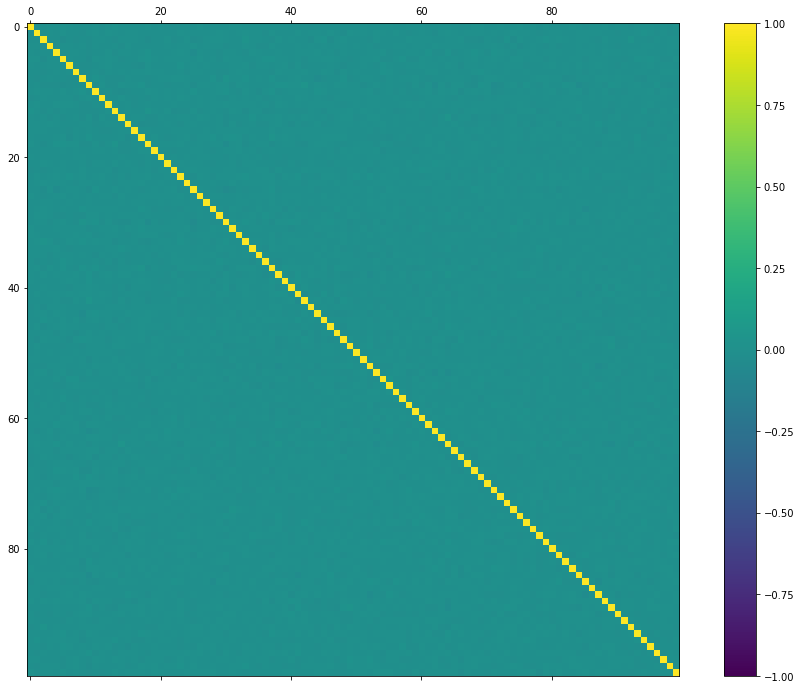

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = df_features_train.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [28]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value=0))
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool']).columns
categorical_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 100
Number of categorical columns: 0
Total number of columns in the feature dataframe: 100


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (250000, 100) to array_features_train.shape: (250000, 100)


### 3.c) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [33]:
# # Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (250000, 100) array_target_train.shape: (250000,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
start_time_module = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LNR', LinearRegression(n_jobs=N_JOBS)))
train_models.append(('ELN', ElasticNet(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsRegressor(n_jobs=N_JOBS)))
# train_models.append(('RNF', RandomForestRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('GBM', GradientBoostingRegressor(random_state=RNG_SEED)))

In [37]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:',np.mean(train_metrics))
print ('Average RMSE for all models is:', math.sqrt((np.mean(train_metrics)*-1)))
print ('Total training time for all models:',(datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   12.5s finished


LNR: -62.370598 (0.459912)
LinearRegression(n_jobs=2)
Model training time: 0:00:12.576267 



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.5s finished


ELN: -63.046978 (0.458276)
ElasticNet(random_state=888)
Model training time: 0:00:02.570083 



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 26.0min finished


KNN: -75.151633 (0.483307)
KNeighborsRegressor(n_jobs=2)
Model training time: 0:26:03.099067 



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 44.1min finished


EXT: -63.483340 (0.460197)
ExtraTreesRegressor(n_jobs=2, random_state=888)
Model training time: 0:44:04.953439 



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 88.6min finished


GBM: -62.148438 (0.457192)
GradientBoostingRegressor(random_state=888)
Model training time: 1:28:36.480123 

Average metrics (neg_mean_squared_error) from all models: -65.24019752341692
Average RMSE for all models is: 8.077140429843778
Total training time for all models: 2:39:04.477347


### 4.b) Spot-checking baseline algorithms

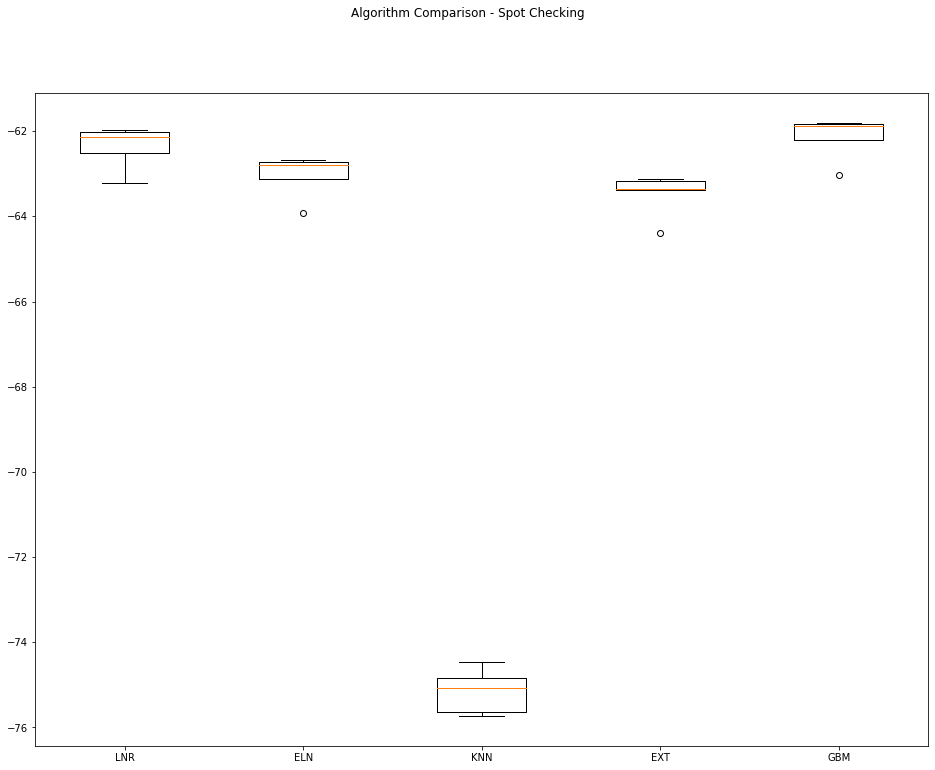

In [38]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [41]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [42]:
# Tuning algorithm #1 - Extra Trees
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model_names.append('ELN')
tune_model1 = ElasticNet(random_state=RNG_SEED)
paramGrid1 = dict(l1_ratio=np.array([0.1, 0.3, 0.5, 0.7, 0.9]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result1.best_score_*-1)))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: -63.046978 using {'l1_ratio': 0.1}
-63.046978 (0.458276) with: {'l1_ratio': 0.1}
-63.046978 (0.458276) with: {'l1_ratio': 0.3}
-63.046978 (0.458276) with: {'l1_ratio': 0.5}
-63.046978 (0.458276) with: {'l1_ratio': 0.7}
-63.046978 (0.458276) with: {'l1_ratio': 0.9}
Best RMSE for the Model is: 7.940212748576703
Model training time: 0:00:11.736399


In [43]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: l1_ratio = 0.1


In [44]:
# Tuning algorithm #2 - Gradient Boosting
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model_names.append('GBM')
tune_model2 = GradientBoostingRegressor(random_state=RNG_SEED)
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result2.best_score_*-1)))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: -61.721578 using {'n_estimators': 500}
-62.148438 (0.457192) with: {'n_estimators': 100}
-61.786429 (0.461263) with: {'n_estimators': 300}
-61.721578 (0.463856) with: {'n_estimators': 500}
Best RMSE for the Model is: 7.856308192951746
Model training time: 14:52:14.797042


In [45]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 500


### 5.b) Compare Algorithms After Tuning

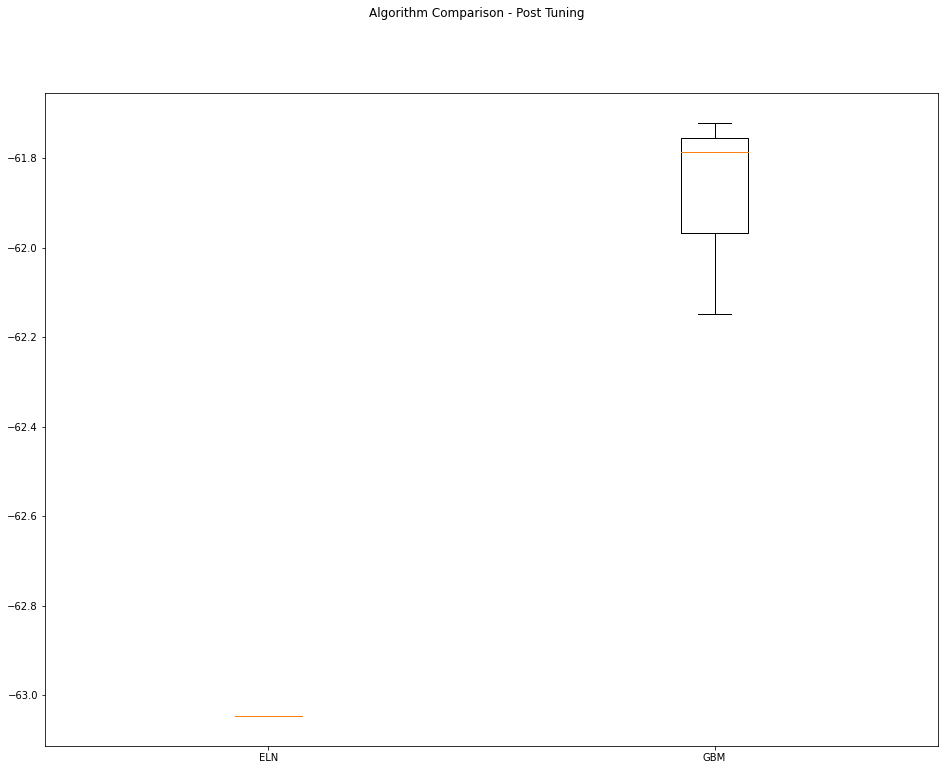

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [48]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [49]:
final_model = GradientBoostingRegressor(n_estimators=best_paramValue2, random_state=RNG_SEED)
final_model.fit(array_features_train, array_target_train)
print(final_model)

GradientBoostingRegressor(n_estimators=500, random_state=888)


### 6.b) Load Test Dataset and Prepare the Submission File

In [50]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021aug/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id        f0   f1        f2        f3          f4        f5         f6  \
0  250000  0.812665   15 -1.239120 -0.893251    295.5770  15.87120   23.04360   
1  250001  0.190344  131 -0.501361  0.801921     64.8866   3.09703  344.80500   
2  250002  0.919671   19 -0.057382  0.901419  11961.2000  16.39650  273.24000   
3  250003  0.860985   19 -0.549509  0.471799   7501.6000   2.80698   71.08170   
4  250004  0.313229   89  0.588509  0.167705   2931.2600   4.34986    1.57187   

         f7         f8  ...       f90        f91       f92      f93       f94  \
0  0.942256  29.898000  ...  0.446389   -422.332  -1.44630  1.69075  1.059300   
1  0.807194  38.421900  ...  0.377179  10352.200  21.06270  1.84351  0.251895   
2 -0.003300  37.940000  ...  0.990140   3224.020  -2.25287  1.55100 -0.559157   
3  0.792136   0.395235  ...  1.396880   9689.760  14.77150  1.41390  0.329272   
4  1.118300   7.754630  ...  0.862502   2693.350  44.18050  1.58020 -0.191021   

         f95      f96     

In [51]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  250000
1  250001
2  250002
3  250003
4  250004


In [52]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

         f0   f1        f2        f3          f4        f5         f6  \
0  0.812665   15 -1.239120 -0.893251    295.5770  15.87120   23.04360   
1  0.190344  131 -0.501361  0.801921     64.8866   3.09703  344.80500   
2  0.919671   19 -0.057382  0.901419  11961.2000  16.39650  273.24000   
3  0.860985   19 -0.549509  0.471799   7501.6000   2.80698   71.08170   
4  0.313229   89  0.588509  0.167705   2931.2600   4.34986    1.57187   

         f7         f8       f9  ...       f90        f91       f92      f93  \
0  0.942256  29.898000  1.11394  ...  0.446389   -422.332  -1.44630  1.69075   
1  0.807194  38.421900  1.09695  ...  0.377179  10352.200  21.06270  1.84351   
2 -0.003300  37.940000  1.15222  ...  0.990140   3224.020  -2.25287  1.55100   
3  0.792136   0.395235  1.20157  ...  1.396880   9689.760  14.77150  1.41390   
4  1.118300   7.754630  1.16807  ...  0.862502   2693.350  44.18050  1.58020   

        f94        f95      f96       f97       f98       f99  
0  1.059300  -3.

In [53]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (150000, 100) to array_features_test.shape: (150000, 100)


In [54]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[7.6915279  4.39615238 7.63944805 ... 5.99830514 6.05371138 6.65019791]


In [55]:
df_kaggle_submission['loss'] = test_predictions
print(df_kaggle_submission.head())

       id      loss
0  250000  7.691528
1  250001  4.396152
2  250002  7.639448
3  250003  6.916384
4  250004  7.780808


In [56]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210907-1011.csv


In [57]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 20:33:08.485852
